In [1]:
#https://www.tensorflow.org/tutorials/quickstart/advanced 

import tensorflow as tf

print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model

import tensorflow.keras as keras

from tabulate import tabulate
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

#import tensorflow.keras.backend as K

2024-08-09 14:51:16.504397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.10.0


In [2]:
# Universal parameters
batchSize = 1100 # batchSize = number of paths to be generated

d = 2 # dimension of forward process

batchSize_DNN = 1 #2 #10 # 20 50
Max_EPOCHS = 600 #1000
Mid_EPOCHS = 200 #300
Min_EPOCHS = 200 #300
lr = .001
seed = 0 #168
tf.random.set_seed(
    seed
)
tf.keras.utils.set_random_seed(
    seed
)

print('Number of paths (sample data) = ', batchSize)
print('batchSize = ', batchSize_DNN)
print('NumEpochs = ', Max_EPOCHS, Mid_EPOCHS, Min_EPOCHS)
print('Learning Rate = ', lr)



X_0 = 100 # initial price
print('initial price = ', X_0) 
V_0 = .15  # initial volatility
print('initial Vol = ', V_0)
K = 80 #85 #90 #95 



mu = .08
print('mu = ', mu )
alpha = 5 
print('alpha = ', alpha)
m = 0 
print('m = ', m)
nu = 1
print('nu = ', nu)
a = nu * np.sqrt(2 * alpha)
print('nu * sqrt(2 alpha ) = ', a)
rho = -.2
print('rho = ', rho)
gamma = 1
print('gamma = ', gamma )
eta = .2 
print('eta = ', eta)
timeSteps = 10 #20 #50 
print('Total number of time steps = ', timeSteps )
r = 0.02 # .05
print('risk free rate r = ', r)
T = 1/4 # terminal time
print('T = ', T)
dt = T / timeSteps
print('dt = ', dt)

#strikes = [70,75,80,85,90,95,100,105,110,115]
# strikes = [i for i in range(70,116,2)]
#print('strikes = ', strikes)
#print('logMoney = ', np.array(strikes) / X_0)
# for loop here 
#ivValues = []
print('-------------Beginning computation-----------------')




Number of paths (sample data) =  1100
batchSize =  1
NumEpochs =  600 200 200
Learning Rate =  0.001
initial price =  100
initial Vol =  0.15
mu =  0.08
alpha =  5
m =  0
nu =  1
nu * sqrt(2 alpha ) =  3.1622776601683795
rho =  -0.2
gamma =  1
eta =  0.2
Total number of time steps =  10
risk free rate r =  0.02
T =  0.25
dt =  0.025
-------------Beginning computation-----------------


In [3]:
# First step is to train the deep neural network y^_{N-1} (a function of X_{N-1}, dW_{N-1}) by:
# input: X_{N-1}, dW_{N-1}
# output: y^_{N} = F(t_{N-1}, X_{N-1}, y^_{N-1}, z_{N-1}, dW_{N-1}) 
# (a custom layer is needed for a F transformation)
# minimizing quadratic loss: E( (y_{N} - y^_{N})^2 ), expectation is taken over all paths
# the best model y*_{N} = best(y^_{N}) is set to be the target of next deep neural network

In [4]:
def trainingData(seed): # = 168):
    tf.random.set_seed(seed)
    std_normal = tf.random.normal([batchSize,  # [x,   [number of paths,
                                   timeSteps + 1,  #  y, =  number of values in each path,            = tensor shape
                                   2],         #  z]    dim of each path 
                                  mean = 0.0,
                                  stddev = 1.0,
                                  dtype = tf.dtypes.float32,
                                  seed = seed,
                                  name = None)
    dW = std_normal * np.sqrt(dt)
    X = tf.Variable(tf.ones([batchSize, timeSteps + 1, 2], 
                            dtype = tf.dtypes.float32) * tf.constant([X_0, V_0]))
    for i in range(timeSteps):
        stockTerm1 = mu * X[:,i, 0] * dt
        stockTerm2 = (.7 / (np.pi) * (tf.math.atan(X[:,i, 1] - 1) + np.pi/2) + .03) * X[:, i,0] * dW[:,i,0] # sigma(Y_t)
        stockTerm3 = -r * X[:,i,0] * dt
        X[:, i+1, 0].assign(X[:,i, 0] + stockTerm1 + stockTerm2 + stockTerm3)
        volTerm1 = alpha * (m - X[:,i,1]) * dt
        volTerm2 = a * (rho *dW[:,i,0] + np.sqrt(1 - rho ** 2)* dW[:,i,1])
        X[:, i+1, 1].assign(X[:, i, 1] + volTerm1 + volTerm2) 
        
       # X = X[:, i+1, :].assign(X[:, i, :] + r*X[:, i, :]*dt + sigma*X[:, i, :]*dW[:, i, :])
    return X, dW

    
#terminal condition
def fun_g(X, K, t):
    # print(X.shape)
    g = tf.math.maximum(K * tf.math.exp((-r * (t/timeSteps) * T)) - X, 0)
    return g



 #X2=X[:,t, 1]
# driver 1    
def fun_f(t, X1, X2, z1, z2):
    sigma = ((.7 / (np.pi)) * (tf.math.atan(X2 - 1) + np.pi/2) + .03)
    term1 = -1 * z1 * ((mu - r) / sigma) 
    term2 = -1 * (1/(2 * gamma)) * ((-(mu - r) / sigma) **2)
    term3 =  (1/(2 * gamma)) * (gamma / 2) * z2 ** 2
    term4 = -1 * (1/(2 * gamma)) * eta * ((mu - r) / sigma) * z2

    regular = term1 + term2 + term3 + term4
    
    return regular
#print(fun_f(1,10,.5,1,2))
# driver 2
def fun_f_bar(t, X1, X2, z1, z2):
    z1 = -1 * z1
    z2 = -1 * z2
    sigma = (.7 / (np.pi) * (tf.math.atan(X2 - 1) + np.pi/2) + .03)
    term1 = -1 * z1 * ((mu - r) / sigma) 
    term2 = -1 * (1/(2 * gamma)) * ((-(mu - r) / sigma) **2)
    term3 =  (1/(2 * gamma)) * (gamma / 2) * z2 ** 2
    term4 = -1 * (1/(2 * gamma)) * eta * ((mu - r) / sigma) * z2

    regular = term1 + term2 + term3 + term4
    
    return -1 * regular

# function F (the estimation of y_{i+1} given t_i, X_i, y_i, z_i, dW_i)
def fun_F(t, X1, X2, y, z1, z2, dW1, dW2):
    F = y - fun_f(t, X1, X2, z1, z2) * dt + z1 * dW1 + z2 * dW2
    return F



# function F (the estimation of y_{i+1} given t_i, X_i, y_i, z_i, dW_i)
def fun_F_bar(t, X1, X2, y, z1, z2, dW1, dW2):
    F = y - fun_f_bar(t, X1, X2, z1, z2)*dt + z1 * dW1 + z2 * dW2
    return F



In [5]:
X, dW = trainingData(seed)
print('sample path = ', X[1,:,:])
# print('sample brownian motion = ', dW[0,:,:])
print('sample BM mean: ', tf.math.reduce_mean(dW), '| variance: ', tf.math.reduce_variance(dW))
                    

sample path =  tf.Tensor(
[[ 1.00000000e+02  1.50000006e-01]
 [ 1.00554573e+02 -2.82164752e-01]
 [ 1.02307930e+02 -1.57119930e-02]
 [ 9.80057449e+01 -2.48888656e-01]
 [ 1.04667213e+02 -3.32593203e-01]
 [ 1.06612518e+02 -3.46326292e-01]
 [ 1.06523796e+02 -4.39549088e-02]
 [ 1.08641037e+02 -5.97284615e-01]
 [ 1.10312263e+02  2.68377781e-01]
 [ 1.19024925e+02  5.41483462e-01]
 [ 1.06819839e+02  5.83199024e-01]], shape=(11, 2), dtype=float32)
sample BM mean:  tf.Tensor(0.001961416, shape=(), dtype=float32) | variance:  tf.Tensor(0.024696153, shape=(), dtype=float32)


2024-08-08 20:33:29.084491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = Flatten()
        
        self.d1_y = keras.layers.Dense(10+d, activation='relu', input_shape=(2,))
        self.d2_y = keras.layers.Dense(10+d, activation='relu')
        self.d3_y = keras.layers.Dense(1)
        
        self.d4_z = keras.layers.Dense(10+d, activation='relu', input_shape=(2,))
        self.d5_z = keras.layers.Dense(10+d, activation='relu')
        self.d6_z = keras.layers.Dense(2)
        
    def call(self, y):
        
        y_0 = tf.reshape(y[:,0], (batchSize_DNN,1), name=None) ## X
        y_1 = tf.reshape(y[:,1], (batchSize_DNN,1), name=None) ## V
        y_2 = tf.reshape(y[:,2], (batchSize_DNN,1), name=None) ## dW1
        y_3 = tf.reshape(y[:,3], (batchSize_DNN,1), name=None) ## dW2
        
        y_raw = tf.concat([y_0,y_1], 1)
        
        y = self.flatten(y_raw)
        y = self.d1_y(y)
        y = self.d2_y(y)
        y = self.d3_y(y)
        
        y_export = y
        
        z = self.flatten(y_raw)
        z = self.d4_z(z)
        z = self.d5_z(z)
        z = self.d6_z(z)
        
        z_export = z
        z_1 = z[:,0]
        z_2 = z[:,1]
       
        p = fun_F(t = time, # not useful
                  X1 = y_0,
                  X2 = y_1,
                  y = y,
                  z1 = z_1,
                  z2 = z_2,
                  dW1 = y_2,
                  dW2 = y_3)
             # t is a placeholder only, not useful, 
             # X is the first column of input data (input data = (X,dW))
             # y is the output of the last dense layer (1st dim of output (Y,z))
             # z is the sigma^T*D_x*y, where D_x*y is the numerical differentiation of y
             # dW is the second column of input data (input data = (X,dW))

        return p, y_export, z_export # dimensions (1, 1, 2)

In [7]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [8]:
train_MSE = tf.keras.metrics.MeanSquaredError(name='train_MSE')
test_MSE = tf.keras.metrics.MeanSquaredError(name='test_MSE')

In [9]:
@tf.function
def train_step(x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training = True)[0]
        loss = loss_object(y_train, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_MSE(y_train, predictions)

In [10]:
@tf.function
def test_step(x_test, y_test):
    predictions = model(x_test, training = False)[0]
    #t_loss = loss_object(y_test, predictions)

    test_MSE(y_test, predictions)

In [11]:
X, dW = trainingData(seed)

In [12]:
# Create an instance of the model 
model = MyModel() 

print("Strike = ", K)
   #DO TERMINAL TIME SEPARATELY 
for time in range(timeSteps-1, -1, -1):
    #model.set_weights(initial_weights)
    
   

    time_plus1 = time + 1
    path_ds = tf.concat([X, dW], axis = 2)
    path_ds = path_ds[:,time,:]
    #print("input data shape:")
    #print(path_ds.shape)
    #print(fun_g(X[:,time_plus1,0], K = K, t = time_plus1).shape)

    if time == timeSteps-1:
        payoff_timeplus1 = fun_g(X[:,time_plus1,0], K = K, t = time_plus1)
    else :
        payoff_timeplus1 = np.loadtxt("Sell-BSDE_predictions_"+str(time_plus1)+"K_"+str(K)+".csv", delimiter = ",", dtype = 'float32')
        payoff_timeplus1 = payoff_timeplus1.reshape((batchSize, 1))
     
   
    #print("output data shape:")
    #print(payoff_timeplus1.shape)
    (x_train, y_train), (x_test, y_test) = (path_ds[0:1000,:], 
                       payoff_timeplus1[0:1000]), (path_ds[1000:1100,:], 
                                                payoff_timeplus1[1000:1100])
    
 

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(batchSize_DNN)

    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batchSize_DNN)#.shuffle(100).batch(batchSize_DNN)

    if time == timeSteps-1:
        EPOCHS = Max_EPOCHS
    elif time < 6:
        EPOCHS = Mid_EPOCHS
    else :
        EPOCHS = Min_EPOCHS    
   
    for epoch in range(EPOCHS):
        train_MSE.reset_states()
        test_MSE.reset_states()
        
        for x_train, y_train in train_ds:
            train_step(x_train, y_train)
        
        for x_test, y_test in test_ds:
            test_step(x_test, y_test)
        
        if (epoch + 1) %100 == 0 :# and verbose == True:
            print(
            f'Epoch {epoch + 1}, '
            f'MSE: {train_MSE.result() * 100}, '
            f'Test MSE: {test_MSE.result() * 100}'
               )

    predictions = model.predict(path_ds, batch_size = batchSize_DNN)
    predictions_time = predictions[0].reshape((batchSize,1))
    predictions_time_y = predictions[1]
    

    print("Time = ", time)
    print(test_MSE(payoff_timeplus1, predictions_time))

    print(np.mean(payoff_timeplus1))
    print(np.mean(predictions_time))
    print(np.mean(predictions_time_y))
    
    np.savetxt("Sell-BSDE_predictions_"+str(time)+"K_"+str(K)+".csv", predictions_time_y, delimiter = ",")

    model.reset_states()
    
    
   
    
    
    
  

Strike =  80
Epoch 100, MSE: 217.69361877441406, Test MSE: 589.1299438476562
Epoch 200, MSE: 52.795135498046875, Test MSE: 175.6112518310547
Epoch 300, MSE: 41.066322326660156, Test MSE: 57.493255615234375
Epoch 400, MSE: 41.09447479248047, Test MSE: 35.63786315917969
Epoch 500, MSE: 23.50020408630371, Test MSE: 36.42090606689453
Epoch 600, MSE: 27.916038513183594, Test MSE: 21.403728485107422
1100/1100 [==============================] - 1s 687us/step
Time =  9
tf.Tensor(0.21375048, shape=(), dtype=float32)
0.32412863
0.34699917
0.37072614
Epoch 100, MSE: 22.033300399780273, Test MSE: 12.401001930236816
Epoch 200, MSE: 18.079036712646484, Test MSE: 5.958347797393799
1100/1100 [==============================] - 1s 566us/step
Time =  8
tf.Tensor(0.0846871, shape=(), dtype=float32)
0.37072614
0.40277788
0.37288627
Epoch 100, MSE: 25.008148193359375, Test MSE: 7.350108623504639
Epoch 200, MSE: 24.56328010559082, Test MSE: 6.510756015777588
1100/1100 [==============================] - 1s 74

In [13]:
print(np.mean(predictions_time_y))

0.27003956


In [14]:
BSDE = np.loadtxt("Sell-BSDE_predictions_"+str(0)+"K_"+str(K)+".csv", delimiter = ",", dtype = 'float32')
BSDE0payoff = np.loadtxt("BSDE0predictions_"+str(0)+"_y.csv", delimiter = ",") 
Price = BSDE - BSDE0payoff
print('Seller Price = ', np.mean(Price))
print('variance = ', np.var(Price))

Seller Price =  0.28178855776786804
variance =  0.0


In [29]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  36        
                                                                 
 dense_7 (Dense)             multiple                  156       
                                                                 
 dense_8 (Dense)             multiple                  13        
                                                                 
 dense_9 (Dense)             multiple                  36        
                                                                 
 dense_10 (Dense)            multiple                  156       
                                                                 
 dense_11 (Dense)            multiple                  2

In [3]:
#implied volatility
def d1(sigma, t, T, S, K, r):
    frac = 1 / (sigma * np.sqrt(T - t))
    secondfactor = np.log(S / K) + (r + ((sigma ** 2) / 2)) * (T - t)
    return frac * secondfactor

def d2(sigma, t, T, S, K, r):
    return d1(sigma, t, T, S, K, r) - (sigma * np.sqrt(T - t))

def put_price(sigma, t, T, S, K, r):
    return (norm.cdf(-d2(sigma, t, T, S, K, r)) * K * np.exp(-r * (T - t))) - (norm.cdf(-d1(sigma, t, T, S, K, r)) * S)

def call_price(sigma, t, T, S, K, r):
    return S*norm.cdf(d1(sigma, t, T, S, K,r)) - K*np.exp(-r*(T - t)*norm.cdf(d2(sigma, t, T, S, K, r)))
def implied_vol(price, t, T, S, K, r):
    sigma1 = 0.1
    sigma2 = 0.7
    value1 = put_price(sigma1, t, T, S, K, r) - price
    value2 = put_price(sigma2, t, T, S, K, r) - price
    
    while value1 * value2 > 0:
        sigma1 = sigma1 - 0.01
        sigma2 = sigma2 + 0.01
        value1 = put_price(sigma1, t, T, S, K, r) - price
        value2 = put_price(sigma2, t, T, S, K, r) - price
    i = 0
    while True:
        i = i + 1
        if value1 * value2 == 0:
            if value1 == 0:
                imp_vol = sigma1 #print('implied volatility=', sigma1)
            elif value2 == 0:
                imp_vol = sigma2 #print('implied volatility=', sigma2)
            break
        elif value1 * value2 < 0:
            midpoint = (sigma1 + sigma2) / 2
            if (put_price(midpoint, t, T, S, K, r) - price) * value1 < 0:
                sigma1 = sigma1
                sigma2 = midpoint
                value1 = put_price(sigma1, t, T, S, K, r) - price
                value2 = put_price(sigma2, t, T, S, K, r) - price

            elif (put_price(midpoint, t, T, S, K, r) - price) * value2 < 0:
                sigma1 = midpoint
                sigma2 = sigma2
                value1 = put_price(sigma1, t, T, S, K, r) - price
                value2 = put_price(sigma2, t, T, S, K, r) - price

        if abs(sigma1 - sigma2) < 0.000001:
            imp_vol = sigma2
            break
    return imp_vol



ivValues = []
strikes = [85,90,95,100,105,110,115]

-----------Buyer prices----------------
Strike = 85 Buyer Price =  0.41112855076789856
Strike = 90 Buyer Price =  0.5957556068897247
Strike = 95 Buyer Price =  1.1179023087024689
Strike = 100 Buyer Price =  2.7797451317310333
Strike = 105 Buyer Price =  5.702035218477249
Strike = 110 Buyer Price =  10.836427956819534
Strike = 115 Buyer Price =  14.771559029817581
-----------Seller prices----------------
Strike = 85 Seller Price =  0.32752981781959534
Strike = 90 Seller Price =  0.6974842250347137
Strike = 95 Seller Price =  2.0171076953411102
Strike = 100 Seller Price =  3.551600903272629
Strike = 105 Seller Price =  7.410900801420212
Strike = 110 Seller Price =  10.598956793546677
Strike = 115 Seller Price =  16.19406482577324

--------------------------------------------------------

  Log_Moneyness    Seller price    Buyer price
---------------  --------------  -------------
             85        0.32753        0.411129
             90        0.697484       0.595756
             95

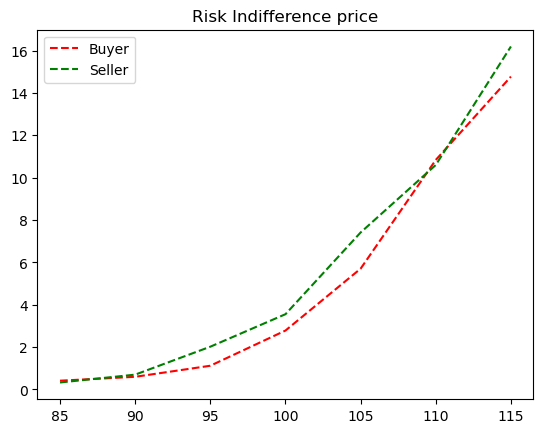

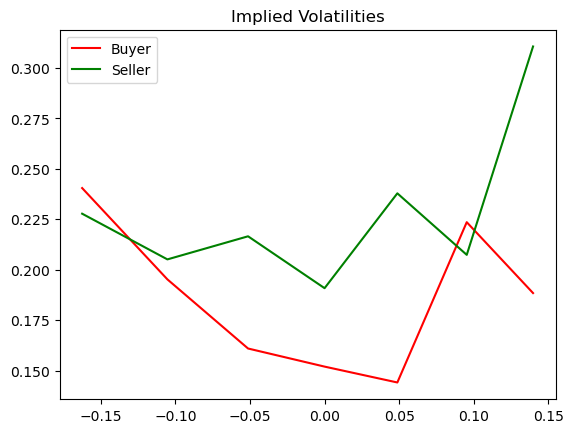

  Log_Moneyness    Seller IV    Buyer IV
---------------  -----------  ----------
     -0.162519      0.22778     0.240491
     -0.105361      0.205117    0.195204
     -0.0512933     0.216572    0.160923
      0             0.19084     0.151945
      0.0487902     0.237875    0.144076
      0.0953102     0.20737     0.223569
      0.139762      0.310705    0.188414


In [4]:
Price_list = []
Strike_list = []
ivValues = []
Price_list_Sell = []
Strike_list_Sell = []
ivValues_Sell = []
print('-----------Buyer prices----------------')
for K in strikes:
    BSDE = np.loadtxt("Buy-BSDE_predictions_"+str(0)+"K_"+str(K)+".csv", delimiter = ",", dtype = 'float32') 
    BSDE0payoff = np.loadtxt("BSDE0predictions_"+str(0)+"_y.csv", delimiter = ",") 
    Price = BSDE0payoff - BSDE
    print('Strike =', K, 'Buyer Price = ', np.mean(Price))
    Strike_list.append(K)
    Price_list.append(np.mean(Price))
    ivValues.append(implied_vol(np.mean(Price), 0, T, 100, K, r))
    
Buyer_price = np.array(Price_list)
Strike_array = np.array(Strike_list)
Buyer_IV = np.array(ivValues)
# plotting the points 
#plt.plot(Strike_array, Buyer_price)
  
# naming the x axis
#plt.xlabel('Strikes')
# naming the y axis
#plt.ylabel('Price')
  
# giving a title to my graph
#plt.title('Risk Indiffernce prices for Buyer')
  
# function to show the plot
#plt.show()



print('-----------Seller prices----------------')


for K in strikes:
    BSDEsell = np.loadtxt("Sell-BSDE_predictions_"+str(0)+"K_"+str(K)+".csv", delimiter = ",", dtype = 'float32') 
    BSDE0payoff = np.loadtxt("BSDE0predictions_"+str(0)+"_y.csv", delimiter = ",") 
    PriceSell = BSDEsell - BSDE0payoff 
    print('Strike =', K, 'Seller Price = ', np.mean(PriceSell))
    Strike_list_Sell.append(K)
    Price_list_Sell.append(np.mean(PriceSell))
    ivValues_Sell.append(implied_vol(np.mean(PriceSell), 0, T, 100, K, r))
    
Buyer_price = np.array(Price_list)
Strike_array = np.array(Strike_list)
Seller_price = np.array(Price_list_Sell)
Buyer_IV = np.array(ivValues)
Seller_IV = np.array(ivValues_Sell)


    
print('')
print('--------------------------------------------------------')
print('')
Price_table = np.stack((Strike_array, Seller_price, Buyer_price), axis=-1)
print (tabulate(Price_table, headers=['Log_Moneyness', 'Seller price', 'Buyer price']))

print('')
log_Money = np.log(Strike_array/100)
Seller_IV = np.array(Seller_IV)
#print('Log Moneyness = ',log_Money)
#print('Seller Implied Volatilities = ', Seller_IV)
#print('Buyer Implied Volatilities = ',Buyer_IV)

#plot prices
plt.plot(Strike_array, Buyer_price, '--',  color='red',label='Buyer')
plt.plot(Strike_array, Seller_price, '--',  color='green',label='Seller')

plt.title("Risk Indifference price")
plt.legend()
plt.show()

#plot Implied volailities
plt.plot(log_Money, Buyer_IV, color='red',label='Buyer')
plt.plot(log_Money, Seller_IV, color='green',label='Seller')

plt.title("Implied Volatilities")
plt.legend()
plt.show()


#Print table of Implied volatility values
data = np.stack((log_Money, Seller_IV, Buyer_IV), axis=-1)
print (tabulate(data, headers=['Log_Moneyness', 'Seller IV', 'Buyer IV']))